In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
data_path = "/content/drive/MyDrive/Stock_test/"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# data = pd.read_csv(data_path + "FPT.csv")
data = pd.read_csv(data_path + "MSN.csv")
# data = pd.read_csv(data_path + "PNJ.csv")
# data = pd.read_csv(data_path + "VIC.csv")




In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


#Mô tả dữ liệu MSN
Dữ liệu gồm 135354 bản ghi và không tồn tại giá trị null

#Tách định dạng thời gian theo ngày và giờ

In [5]:
data['Date'] = data['Date/Time'].str.split().str[0]
data['Time'] = data['Date/Time'].str.split().str[1]


#Loại bỏ các cột không cần thiết

In [6]:
data = data.drop(['Date/Time', 'Open Interest'], axis=1)

#Nhóm dữ liệu theo từng ngày

In [7]:
list_day = []
df_day_colume_name = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
data_group_by_day = data['Date'].drop_duplicates().to_list()
for date in data_group_by_day:
  row = data[(data['Date'] == date)]
  max_high = row['High'].max()
  min_high = row['Low'].min()
  first_open = row.iat[0,1]
  last_close = row.iat[len(row)-1,4]
  sum_volume = row['Volume'].sum()
  list_day.append([date, max_high, min_high, first_open, last_close, sum_volume])

df_day = pd.DataFrame(list_day, columns = df_day_colume_name)
# df_day.head(5)

#Tính biến động giá cổ phiếu

In [8]:
change = [0]
for i in range(len(list_day)-1):
  change.append(df_day.iat[i+1,4] - df_day.iat[i,4])
df_day['Change'] = change


In [9]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    748 non-null    object 
 1   Open    748 non-null    float64
 2   High    748 non-null    float64
 3   Low     748 non-null    float64
 4   Close   748 non-null    float64
 5   Volume  748 non-null    int64  
 6   Change  748 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 41.0+ KB


In [10]:
df_day.head(len(df_day))

,Date,Open,High,Low,Close,Volume,Change
0,12/25/2017,75.4,73.00,73.10,74.2,207370,0.0
1,12/26/2017,75.5,74.30,74.90,75.5,403710,1.3
2,12/27/2017,75.7,74.80,74.90,75.0,517920,-0.5
3,12/28/2017,76.0,74.50,75.00,75.7,377030,0.7
4,12/29/2017,77.0,76.00,76.00,76.7,226880,1.0
...,...,...,...,...,...,...,...
743,12/16/2020,83.6,82.91,83.01,83.5,648540,0.0
744,12/17/2020,84.3,82.90,83.50,84.0,1179730,0.5
745,12/18/2020,84.3,83.70,83.70,84.1,1417470,0.1
746,12/21/2020,85.0,83.40,85.00,83.8,827020,-0.3


#Tổng quan dữ liệu MSN sau chuẩn hóa
Sau khi nhóm theo ngày dữ liệu còn 748 bản ghi \\
Thời gian từ 25/12/2017 đến 22/12/2020

#Chuẩn bị dữ liệu training

#Kiểm tra mức độ tương quan

In [11]:
data_setup = df_day.drop(['Date', 'Change'], axis=1)
data_setup.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.995732,0.996786,0.997477,-0.285659
High,0.995732,1.000000,0.997286,0.996062,-0.334361
Low,0.996786,0.997286,1.000000,0.993677,-0.313134
Close,0.997477,0.996062,0.993677,1.000000,-0.297848
Volume,-0.285659,-0.334361,-0.313134,-0.297848,1.000000


#Đánh giá
Ta có thể thấy độ tương quan của Volume chỉ khoảng 0.3, nhỏ hơn nhiều so với các thuộc tính khác (>= 0.99). Như vậy ta có thể loại bỏ

#Phân chia tập dữ liệu

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Xác định dữ liệu train và test
X = df_day[['Open', 'High', 'Low']]
y = df_day[['Change']]

# Đưa về phân phối chuẩn
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

# Chia dữ liệu 80% train, 20% test
index = int(len(df_day)*0.8)
X_train, X_test = X[:index], X[index:]
y_train, y_test = y[:index], y[index:]



#Huấn luyện và dự đoán

#Áp dụng Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_pred, y_test))

print(rmse)

1.3174415856753068


#Vẽ biểu đồ tương quan

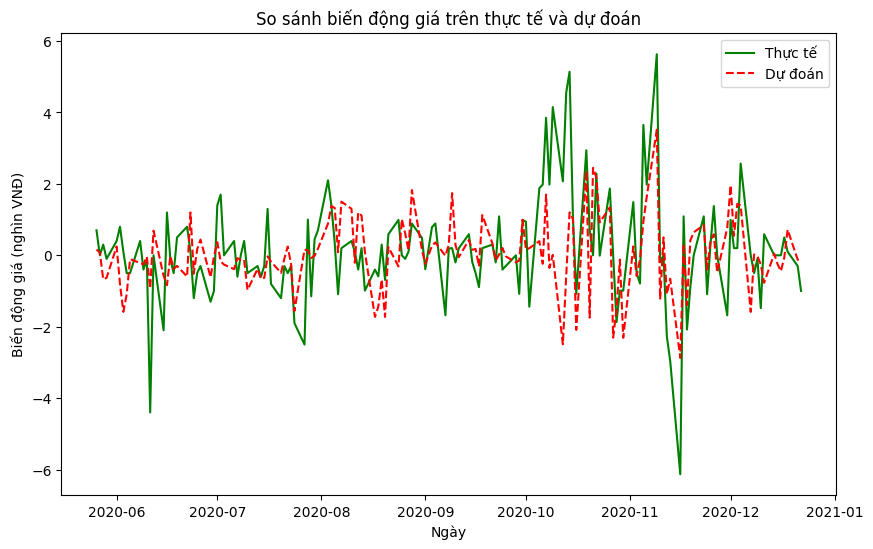

In [14]:

df = df_day.copy()

plt.figure(figsize=(10, 6))
df['Date'] = pd.to_datetime(df['Date'])

plt.plot(df['Date'][index:], df['Change'][index:], label='Thực tế', color='green')

plt.plot(df['Date'][index:], y_pred, label='Dự đoán', color='red', linestyle='dashed')

plt.title('So sánh biến động giá trên thực tế và dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Biến động giá (nghìn VNĐ)')
plt.legend()
plt.show()


#Kết luận

Xây dựng được model dự đoán giá cổ phiếu đơn giản \\
Model dự đoán biến động còn hạn chế ở một vài thời điểm